## BIOENG-310: Neuroscience Foundations for Engineers

Notebook created by Martin Schrimpf, edited by Alejandro Rodriguez Guajardo and Yingtian Tang.

# Week 5: Data visualization and linear probing for V1 neural activities

This week, we **visualize neural firing data** from the primary visual cortex (V1) of a macaque (--% add reference). V1 is known to encode low-level features of visual stimuli, such as texture. To assess this, we apply a technique known as **linear readout** or **linear probing**.

The exercise is written in this *jupyter notebook*, which is a notebook of interleaved Markdown (--% add reference) and Python blocks. All of the blocks can be executed: Markdown blocks turn into text (so when they look strange, just execute them); Python blocks execute the code while keeping the variables so they can be used in other Python blocks. You can check more information on the basics of jupyter notebook starting from [this section of the whole webpage](https://jupyter-notebook.readthedocs.io/en/latest/notebook.html#notebook-user-interface).

The notebook consists of the following sessions:
- **Load Data**: load the experimental V1 neural data
- **Stimuli**: load the stimuli used for the recording experiment
- **Data visualization**: visualize the timeseries of V1 firing patterns (lots of work)
- **Linear readout / linear probing**: use V1 activities to predict the texture of stimuli (lots of work)

Please complete the code in the sections marked %%...%% based on the given instructions and context. Then, run all the blocks to see the results.

Enjoy the journey! 🚀

**Before you begin**, make sure you have all dependencies installed (see `requirements.txt` in this week's folder). Alternatively, you can install them by executing the following block. (The following code might require you to restart runtime, which is fine)

In [1]:
!pip install jupyter brainscore-vision matplotlib

### Load Data

At the current state, it can unfortunately often be difficult to access brain recordings. Not all groups share their data (although new regulations are improving this), and even if the data is accessible it is often difficult to interact with due to non-standard file formats, missing/unclear metadata, and obscure processing pipelines.

That being said, we will here save you the headache by starting from a packaged and standardized dataset.
This data was first published by [Freeman* & Ziemba* et al. 2013](https://www.nature.com/articles/nn.3402) and subsequently packaged into the **[Brain-Score](www.brain-score.org)** platform.
The format of the data here is in [xarray](https://xarray.dev), a structure allowing for multi-dimensional data with multiple metadata along all dimensions. If you know pandas, xarray is the multi-dimensional extension of it. Check basics of xarray here --% and pandas here --%.

In [3]:
import brainscore_vision

# brainscore will download the data for you
data = brainscore_vision.load_dataset('FreemanZiemba2013.public')

# we'll focus on only V1 recordings in this exercise
v1_data = data.sel(region='V1')

# By just typing the name of a variable, jupyter will show its content.
# In this case, the xarray 'v1_data' will be presented with (scroll in the below to have a full view; toggle on the left to show/hide them):
#   1. basics of this data structure: bytes, shape, data type, etc.
#   2. a graphical representation of its different dimensions
#   3. a section called 'coordinates' that shows the names of the dimensions and their associated values
v1_data

brainscore-storage/brainio-brainscore/stimulus_FreemanZiemba2013_aperture-public.zip: 100%|██████████| 5.31M/5.31M [00:00<00:00, 10.8MB/s]


<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    time_bin: 300,
                                                                    presentation: 2700)>
dask.array<getitem, shape=(102, 300, 2700), dtype=float64, chunksize=(102, 300, 2700), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id                 (neuroid_id) int64 1 2 3 4 5 ... 99 100 101 102
  * time_bin                   (time_bin) MultiIndex
  - time_bin_start             (time_bin) int64 0 1 2 3 4 ... 296 297 298 299
  - time_bin_end               (time_bin) int64 1 2 3 4 5 ... 297 298 299 300
  * presentation               (presentation) MultiIndex
  - repetition                 (presentation) int64 0 1 2 3 4 ... 15 16 17 18 19
  - image_id                   (presentation) object 'dfa618e0503a4251582450e...
  - stimulus_id                (presentation) object 'dfa618e0503a4251582450e...
  - sample                     (presentation) int64 2 2 2 2 2 2 ... 2 2 2 2 2 2
  - filename                   (presentation) object 'noise-320x320-im327-smp...
  - image_file_sha1            (presentation) object 'dfa618e0503a4251582450e...
  - image_file_name            (presentation) object 'noise-320x320-im327-smp...
  - texture_family             (presentation) int64 327 327 327 327 ... 71 71 71
  - resolution                 (presentation) object '320x320' ... '320x320'
  - id                         (presentation) int64 133388 133388 ... 133334
  - image_id_without_aperture  (presentation) object '0e8609dc2778a848d7ed8b3...
  - texture_type               (presentation) object 'noise' ... 'texture'
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

Let's get a basic understanding of the neural recording by examining the *coordinates*.

How many presentation trials? --> 2700 (20 repetitions per image and 135 unique images).

How many neural sites? --> 102 sites in V1.

The temporal resolution of the recording is 1 ms per time bin. Then, how long is each trial? --> 300ms.

The *neural site* is recorded from a single electrode stick into the macaque brain (--% need refinement). You guess: does each neural site record from a single neuron? --> not necessarily, can also be multi-unit activity. (--% more information)

### Stimuli

How did this data come about in the first place? Primate subjects were presented with images while experimenters were recording from early visual cortex.

What are those images?

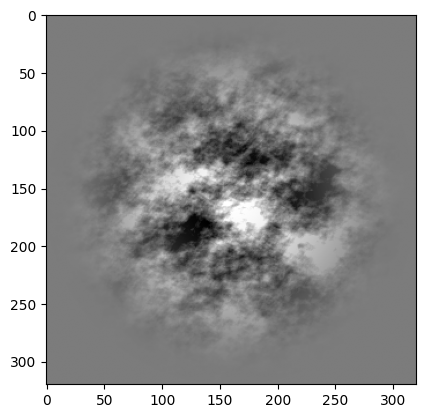

In [4]:
%matplotlib inline
from matplotlib import pyplot, image

# The xarray 'v1_data' has 3 attributes (accesse all of them by 'v1_data.attrs')
#   1. stimulus_set_identifier: name of the stimulus set
#   2. stimulus_set: a brainscore StimulusSet (a subclass of pandas.Dataframe) that records all the information about the stimulus set
#   3. identifier: name of the whole experiment
stimuli = v1_data.stimulus_set

# a shortcut to access the *first* stimulus is in the stimulus set
single_stimulus_id = stimuli['stimulus_id'].values[0]

# use a method 'get_stimulus' of StimulusSet to get the stimulus storage path given the id
image_path = stimuli.get_stimulus(single_stimulus_id)

# show the image using matplotlib
image_content = image.imread(image_path)
pyplot.imshow(image_content, cmap='gray')
pyplot.show()

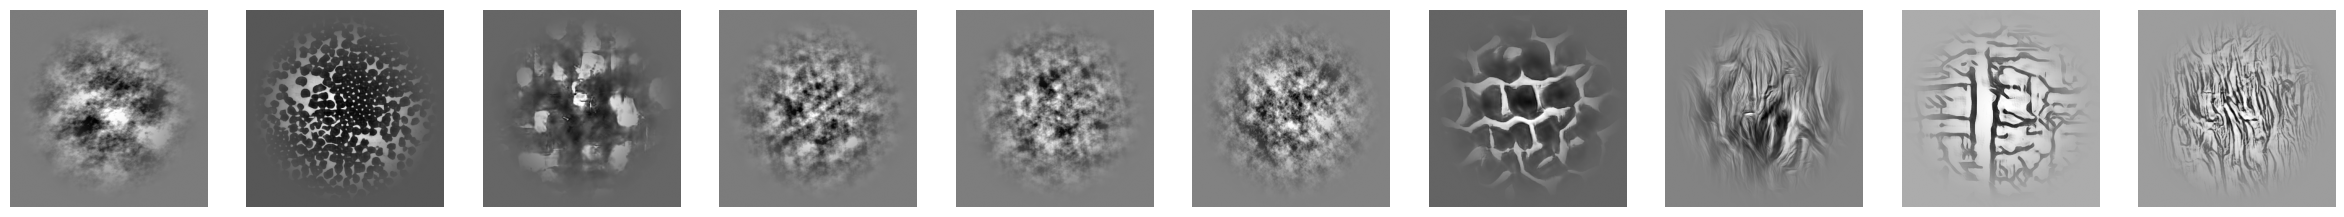

In [5]:
# Let's look at some more stimuli.
fig, axes = pyplot.subplots(nrows=1, ncols=10, figsize=(30, 3))
for i, ax in enumerate(axes.flatten()):
    current_stimulus_id = stimuli['stimulus_id'].values[i]  # accessing more stimuli
    image_path = stimuli.get_stimulus(current_stimulus_id)
    image_content = image.imread(image_path)
    ax.imshow(image_content, cmap='gray')
    ax.set_axis_off()
pyplot.show()

### Data visualization

Now that we've seen the images shown to the macaques, let's check the neural activity recorded in V1. It's always a good idea to first plot the raw activity data before running any complex analysis. This helps ensure the data looks as expected and there are no obvious issues.

Let's start with the response to the single stimulus that we visualized in the previous section.

In [12]:
single_stimulus_id = stimuli['stimulus_id'].values[0]

# xarray.sel method allows slicing the currency xarray along one/multiple coordinate(s), and returns another xarray
stimulus_data = v1_data.sel(stimulus_id=single_stimulus_id)

# before executing, think about the shape/coordinates of this xarray
stimulus_data

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    time_bin: 300,
                                                                    presentation: 20)>
dask.array<getitem, shape=(102, 300, 20), dtype=float64, chunksize=(102, 300, 20), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id                 (neuroid_id) int64 1 2 3 4 5 ... 99 100 101 102
  * time_bin                   (time_bin) MultiIndex
  - time_bin_start             (time_bin) int64 0 1 2 3 4 ... 296 297 298 299
  - time_bin_end               (time_bin) int64 1 2 3 4 5 ... 297 298 299 300
  * presentation               (presentation) MultiIndex
  - repetition                 (presentation) int64 0 1 2 3 4 ... 15 16 17 18 19
  - image_id                   (presentation) object '21041db1f26c142812a6627...
  - sample                     (presentation) int64 5 5 5 5 5 5 ... 5 5 5 5 5 5
  - filename                   (presentation) object 'noise-320x320-im38-smp5...
  - image_file_sha1            (presentation) object '21041db1f26c142812a6627...
  - image_file_name            (presentation) object 'noise-320x320-im38-smp5...
  - texture_family             (presentation) int64 38 38 38 38 ... 38 38 38 38
  - resolution                 (presentation) object '320x320' ... '320x320'
  - id                         (presentation) int64 133032 133032 ... 133032
  - image_id_without_aperture  (presentation) object '6ddcf4b55f9151ac7725070...
  - texture_type               (presentation) object 'noise' 'noise' ... 'noise'
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

We see that this single stimulus was shown a total of 20 times (repetitions), has 205 neural sites recorded, and was collected over 300 time-bins (in this case 1 ms each).
In visual neuroscience, repeated trials are usually conducted to average out noise. Let's do just that by averaging all the repetitions.

In [14]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition

# average over repeated repetitions of the same stimulus using the brainscore function
averaged_stimulus_data = average_repetition(stimulus_data)

# remove (or 'squeeze') the singleton dimension after the averaging along it
averaged_stimulus_data = averaged_stimulus_data.squeeze('presentation')

averaged_stimulus_data

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    time_bin: 300)>
dask.array<getitem, shape=(102, 300), dtype=float64, chunksize=(102, 300), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id      (neuroid_id) int64 1 2 3 4 5 6 7 ... 96 97 98 99 100 101 102
  * time_bin        (time_bin) MultiIndex
  - time_bin_start  (time_bin) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  - time_bin_end    (time_bin) int64 1 2 3 4 5 6 7 ... 295 296 297 298 299 300
    presentation    object ('21041db1f26c142812a66277c2957fb3e2070916', 5, 'n...
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

Now we visualize the averaged recordings for this specific stimulus:

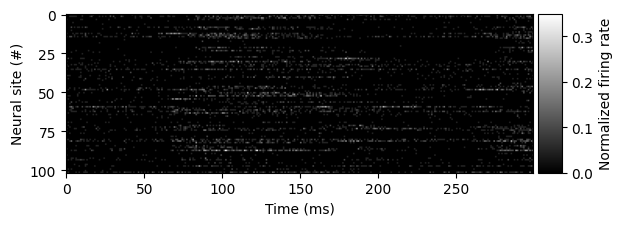

In [18]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = pyplot.subplots()
colormap = ax.imshow(averaged_stimulus_data.transpose('neuroid_id', 'time_bin').values, cmap='gray')

def add_colorbar(fig, ax, colormap):
    divider = make_axes_locatable(ax)  # make space for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    colorbar = fig.colorbar(colormap, cax=ax_colorbar)
    colorbar.set_label('Normalized firing rate')

add_colorbar(fig, ax, colormap)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neural site (#)')
pyplot.show()

Cool! Lots of activity. But always think of what the 'time' and 'neural site' dimension mean. This will be helpful.

This was for one single stimulus, let's see what the data looks like on average across all the stimuli.

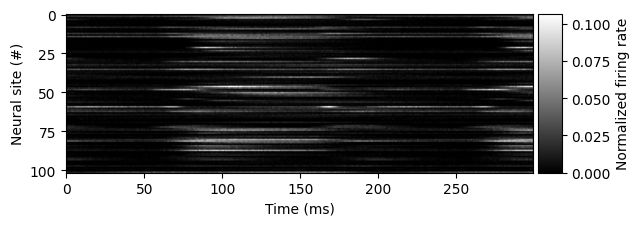

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = pyplot.subplots()

# average over all stimuli, all repetitions
averaged_v1_data = v1_data.mean('presentation')

colormap = ax.imshow(averaged_v1_data.transpose('neuroid_id', 'time_bin').values, cmap='gray')
add_colorbar(fig, ax, colormap)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neural site (#)')
pyplot.show()

There is another way to show these activity patterns: plotting them as timeseries.

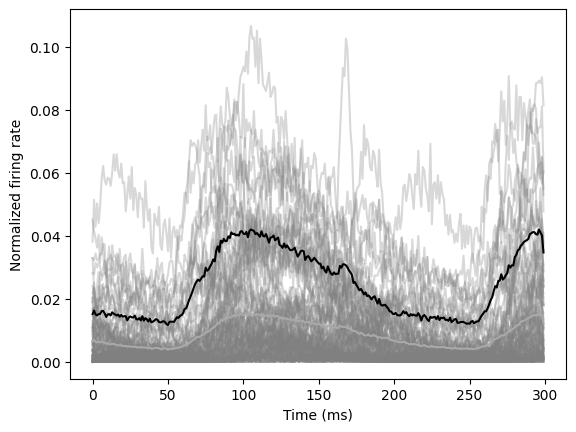

In [27]:
averaged_v1_data.load()  # make sure all data is loaded (sometimes the xarray is lazily loaded)

fig, ax = pyplot.subplots()
time_bins = averaged_v1_data['time_bin_start'].values

# plot individual sites
neural_sites = averaged_v1_data['neuroid_id'].values
for neural_site in neural_sites:
    match_site = [neuroid_id == neural_site for neuroid_id in neural_sites]
    site_data = averaged_v1_data[{'neuroid_id': match_site}].squeeze()
    ax.plot(time_bins, site_data.values, color='gray', alpha=0.3)

# also plot site average
site_average = averaged_v1_data.mean('neuroid_id')
ax.plot(time_bins, site_average.values, color='darkgray')

# and the sites that are more active -- let's say the sites that at some point are active above 0.05
active_sites = (averaged_v1_data > 0.05).any('time_bin')
active_sites = averaged_v1_data[{'neuroid_id': active_sites}].mean('neuroid_id')
ax.plot(time_bins, active_sites.values, color='black')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Normalized firing rate')
pyplot.show()

What happens at time=0ms? --> When the stimulus is first shown.

When are most neural sites start to become active? --> Around 70ms.

Why does it take time for sites to become active? --> Transmission between biological neurons is non-instantaneous.

You guess: why is there activity again at around 270ms? --> Each image was shown for 100ms followed by 100ms gray followed by the next image. I.e. the next image comes on at 200ms, the data is slightly overlapping across trials.

You guess: why do some sites show small activity (e.g. towards the bottom)? --> Could be hardware deficits, sites that are not visually driven, or not driven by the stimuli shown in this experiment.

#### Bonus: Reproducing a figure from the paper

In the original [paper](https://www.nature.com/articles/nn.3402) we took the data from, Figure 2b identifies a contrast of neural responses to noise and naturalistic stimuli between neural sites in V1 and V2.
In other words, the neural activity shows different patterns across different stimulus types: texture *vs.* noise.

With our data processing so far, we can reproduce this figure.

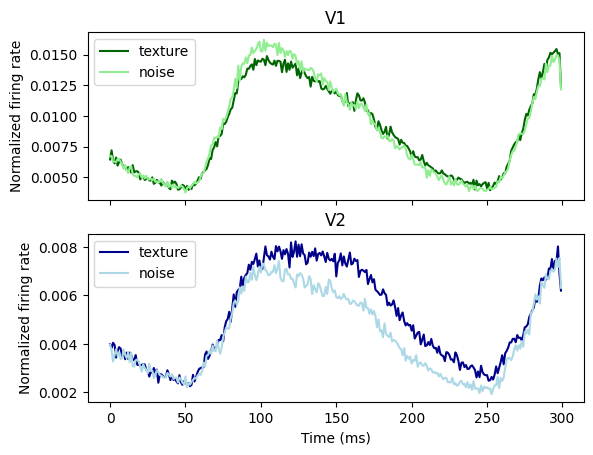

In [28]:
from brainio.assemblies import NeuronRecordingAssembly

full_data = brainscore_vision.load_dataset('FreemanZiemba2013.public')  # make sure we have both the V1 and V2 data again

def process_data(data: NeuronRecordingAssembly) -> tuple[NeuronRecordingAssembly, NeuronRecordingAssembly]:
    data = data.mean('neuroid_id')
    # note that in the paper these values are further normalized by each site's maximum firing rate
    data.load()  # make sure data is loaded
    texture_data = data.sel(texture_type='texture').mean('presentation')
    noise_data = data.sel(texture_type='noise').mean('presentation')
    return texture_data, noise_data

v1_data = full_data.sel(region='V1')
v2_data = full_data.sel(region='V2')

fig, axes = pyplot.subplots(nrows=2)

for title, ax, data, base_color in zip(
        ['V1', 'V2'], axes, [v1_data, v2_data], ['green', 'blue']):
    texture_data, noise_data = process_data(data)
    time_bins = data['time_bin_start'].values
    ax.plot(time_bins, texture_data.values, color=f"dark{base_color}", label='texture')
    ax.plot(time_bins, noise_data.values, color=f"light{base_color}", label='noise')
    ax.legend()
    ax.set_title(title)
    ax.set_ylabel('Normalized firing rate')
    if title == 'V2':
        ax.set_xlabel('Time (ms)')
    else:
        ax.xaxis.set_ticklabels([])  # hide tick labels on top plot
pyplot.show()

### Linear readout / linear probing

Since neural firing patterns vary with different stimuli, we want to understand what information these patterns truly encode about the stimuli.

A very common technique to investigate the informational content of data is to see if a linear regression can predict some variables of interests.

In our case, we're interested in whether V1 activity can predict if the stimuli contain texture or if they are simply pure noise.

#### Time-averaging

To make things simpler, we will average out the time dimension from now on.

In other words, we assume that the time-averaged activity magnitude, without considering dynamics, already encodes texture information.

As we observed before, most of the interesting signal is localized to 50-200ms. Let's average out the time dimension in that range so that we can focus on this signal. We also again average over the repetitions of each stimulus.

In [55]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition

def average_time_range(data, time_window):
    data = data.sel(time_bin=[(t, t + 1) for t in range(*time_window)])
    data = data.mean(dim='time_bin', keep_attrs=True)
    return data

time_average = average_time_range(v1_data, time_window = (50, 200))
time_average = average_repetition(time_average)
time_average

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    presentation: 135)>
dask.array<transpose, shape=(102, 135), dtype=float64, chunksize=(102, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id                 (neuroid_id) int64 1 2 3 4 5 ... 99 100 101 102
  * presentation               (presentation) MultiIndex
  - image_id                   (presentation) object '00b8ffbd5d99263c71762f8...
  - stimulus_id                (presentation) object '00b8ffbd5d99263c71762f8...
  - sample                     (presentation) int64 9 3 2 12 15 ... 13 6 9 10 7
  - filename                   (presentation) object 'noise-320x320-im48-smp9...
  - image_file_sha1            (presentation) object '00b8ffbd5d99263c71762f8...
  - image_file_name            (presentation) object 'noise-320x320-im48-smp9...
  - texture_family             (presentation) int64 48 60 71 393 ... 23 52 99
  - resolution                 (presentation) object '320x320' ... '320x320'
  - id                         (presentation) int64 133313 133422 ... 133210
  - image_id_without_aperture  (presentation) object 'c3f8b361da8a42c440a46f2...
  - texture_type               (presentation) object 'noise' ... 'noise'
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

Now without the time dimension, we're left with the responses 102 V1 neural sites to 135 stimuli.

We can visualize this again using an 'imshow' plot, but please note that the axes have changed compared to the previous plots.

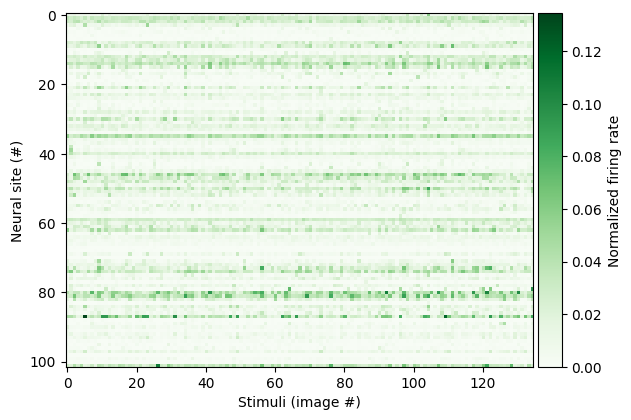

In [56]:
fig, ax = pyplot.subplots()
colormap = ax.imshow(time_average.values, cmap='Greens')
add_colorbar(fig, ax, colormap)
ax.set_xlabel('Stimuli (image #)')
ax.set_ylabel('Neural site (#)')
pyplot.show()

Arguably it's not super obvious how much signal there is that is specific to images. We will analyze this in detail in the next few steps.

#### Predicting/decoding the texture types

For this dataset, there are two types of stimuli: 'noise' images and 'texture' images. Let's see if we can differentiate among them using the V1 neural data.

Concretely, we fit a classifier that predicts the texture type based on the neural firing rates.
We want to see if we can really *predict* unseen data. Therefore, we split our data into a `train` and a `validation` split. We train the classifier only on the `train` split. Then, we check if the trained classifier has high accuracy on the `validation` split.

The scikit-learn package has some great utilities for such simple classic machine learning tools.

Note: In research, we would also use an additional `test` split that we hold out altogether and only analyze at the very end when all model parameters are locked in, to avoid implicit overfitting to the data.


In [57]:
from sklearn.model_selection import train_test_split

# a shortcut for getting all the stimulus ids as a numpy array
stimulus_ids = time_average['stimulus_id'].values

# use 80% for training, 20% for validation
train_stimuli, val_stimuli = train_test_split(stimulus_ids, train_size=0.8, random_state=3)

# Unfortunately, xarray.sel does not support slicing with multiple values.
# We have to use xarray.isel with binary masking to select the slices we want.
# See more information on xarray slice at: https://docs.xarray.dev/en/latest/user-guide/indexing.html#vectorized-indexing
train_data = time_average.isel(presentation=time_average.stimulus_id.isin(train_stimuli))
val_data = time_average.isel(presentation=time_average.stimulus_id.isin(val_stimuli))

What's chance accuracy on this dataset?

In [58]:
from numpy.random import RandomState

train_y = train_data['texture_type'].values
random_baseline = RandomState(seed=42).choice(train_y, replace=False, size=len(train_y))
chance_accuracy = (random_baseline == train_y).mean()
print("chance performance is", chance_accuracy)

chance performance is 0.5


Note that chance is actually exactly 50% in this specific case; depending on randomness one run of this might give values slightly below/above 0.5.  

Now we train a linear regression from the train brain data to the train stimulus types.

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

linear_readout = LogisticRegression()

# sometimes xarray can be used as a numpy array, but you need to be careful about the shape
train_x = train_data.transpose('presentation', 'neuroid_id').values
train_y = train_data['texture_type'].values

# normalize data
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)

# fit the decoder
linear_readout.fit(train_x, train_y)

# double-checking that the fitting worked
train_predictions = linear_readout.predict(train_x)
train_accuracy = (train_predictions == train_y).mean()
print("train accuracy is", train_accuracy)

train accuracy is 1.0


Great, we were able to (over)fit the training data. How well does this work on the validation data?

In [63]:
val_x = scaler.transform(val_data.transpose('presentation', 'neuroid_id').values)
val_y = val_data['texture_type'].values
val_accuracy = linear_readout.score(val_x, val_y)
print("validation accuracy is", val_accuracy)

validation accuracy is 0.7407407407407407


Not so bad.

Why did we not get 100% validation accuracy? --> noisy data, imperfect classifier, generalization to unseen data

How could you improve the accuracy of the classifier? --> filter noisy neural sites, collect more neural data, regularization.

Taking the [paper](https://www.nature.com/articles/nn.3402)'s Figure 2 into account, do you think the classifier performance with V2 data would be different than with V1? --> likely higher since V2 neurons seem to more strongly differentiate between noise and texture images.